Importing required packages

In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

Importing data

Dataset: https://www.kaggle.com/mczielinski/bitcoin-historical-data

In [13]:
#import the dataset
def getrealprice(csv):
    df = pd.read_csv(csv)
    df['Date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date
    group = df.groupby('Date') #group prices into date
    Real_Price = group['Weighted_Price'].mean() #take mean price of date
    return Real_Price

In [14]:
Real_price= getrealprice ('coinbase.csv')
Real_Price.head()

Date
2014-12-01    366.775068
2014-12-02    375.943001
2014-12-03    377.882701
2014-12-04    377.991743
2014-12-06    378.000000
Name: Weighted_Price, dtype: float64

Training and testing split

In [16]:
#split data
def datasplit (prediction_days):
    df_train= Real_Price[:len(Real_Price)-prediction_days]
    df_test= Real_Price[len(Real_Price)-prediction_days:]
    return df_train, df_test

In [17]:
df_train, df_test= datasplit(30)

In [19]:
#process data
def traintransform(df_train):
    training_set=df_train.values
    training_set=np.reshape(training_set, (len(training_set), 1))
    training_set=min_max_scaler.fit_transform(training_set)
    X_train= training_set[0:len(training_set)-1] #sequential split on training set for RNN
    y_train= training_set[1:len(training_set)]
    X_train= np.reshape(X_train, (len(X_train), 1, 1)) #len(X_train) samples, 1 timestep, 1 feature
    return X_train, y_train

In [20]:
X_train, y_train= traintransform (df_train)

Training model

In [6]:
#initialising the RNN
regressor = Sequential()
regressor.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)))#adding the input layer and the LSTM layer
regressor.add(Dense(units = 1))#adding the output layer
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')#compiling the RNNregressor
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)#fitting the RNN to the Training set

Epoch 1/100
1240/1240 [==============================] - 2s 1ms/step - loss: 0.0425
Epoch 2/100
1240/1240 [==============================] - 1s 652us/step - loss: 0.0377
Epoch 3/100
1240/1240 [==============================] - 1s 657us/step - loss: 0.0349
Epoch 4/100
1240/1240 [==============================] - 1s 652us/step - loss: 0.0318
Epoch 5/100
1240/1240 [==============================] - 1s 655us/step - loss: 0.0283
Epoch 6/100
1240/1240 [==============================] - 1s 661us/step - loss: 0.0245
Epoch 7/100
1240/1240 [==============================] - 1s 659us/step - loss: 0.0203
Epoch 8/100
1240/1240 [==============================] - 1s 694us/step - loss: 0.0160
Epoch 9/100
1240/1240 [==============================] - 1s 667us/step - loss: 0.0119
Epoch 10/100
1240/1240 [==============================] - 1s 676us/step - loss: 0.0081
Epoch 11/100
1240/1240 [==============================] - 1s 671us/step - loss: 0.0050
Epoch 12/100
1240/1240 [==============================

1240/1240 [==============================] - 1s 652us/step - loss: 1.5665e-04
Epoch 92/100
1240/1240 [==============================] - 1s 651us/step - loss: 1.5376e-04
Epoch 93/100
1240/1240 [==============================] - 1s 655us/step - loss: 1.5798e-04
Epoch 94/100
1240/1240 [==============================] - 1s 648us/step - loss: 1.5748e-04
Epoch 95/100
1240/1240 [==============================] - 1s 660us/step - loss: 1.5506e-04
Epoch 96/100
1240/1240 [==============================] - 1s 664us/step - loss: 1.5684e-04
Epoch 97/100
1240/1240 [==============================] - 1s 665us/step - loss: 1.5692e-04
Epoch 98/100
1240/1240 [==============================] - 1s 653us/step - loss: 1.5640e-04
Epoch 99/100
1240/1240 [==============================] - 1s 679us/step - loss: 1.5636e-04
Epoch 100/100
1240/1240 [==============================] - 1s 652us/step - loss: 1.5902e-04


In [21]:
#making the predictions
def testtransform(test_set):
    test_set = df_test.values
    inputs = np.reshape(test_set, (len(test_set), 1))
    inputs = min_max_scaler.transform(inputs)
    inputs = np.reshape(inputs, (len(inputs), 1, 1))
    return inputs

In [26]:
inputs=testtransform(test_set)
predicted_price = regressor.predict(inputs)
predicted_price = min_max_scaler.inverse_transform(predicted_price)

In [29]:
#visualising the results
def plotting (test_set,df_test, predicted_price):
    plt.figure(figsize=(25,15), dpi=50, facecolor='w', edgecolor='k')
    ax = plt.gca()  
    plt.plot(test_set, color = 'red', label = 'Real BTC Value')
    plt.plot(predicted_price, color = 'blue', label = 'Predicted BTC Price')
    plt.title('BTC Price Prediction', fontsize=20)
    df_test = df_test.reset_index()
    x=df_test.index
    labels = df_test['Date']
    plt.xticks(x, labels, rotation = 'vertical')
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(10)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(10)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('BTC Price(USD)', fontsize=20)
    plt.legend(loc=2, prop={'size': 25})
    plt.show()

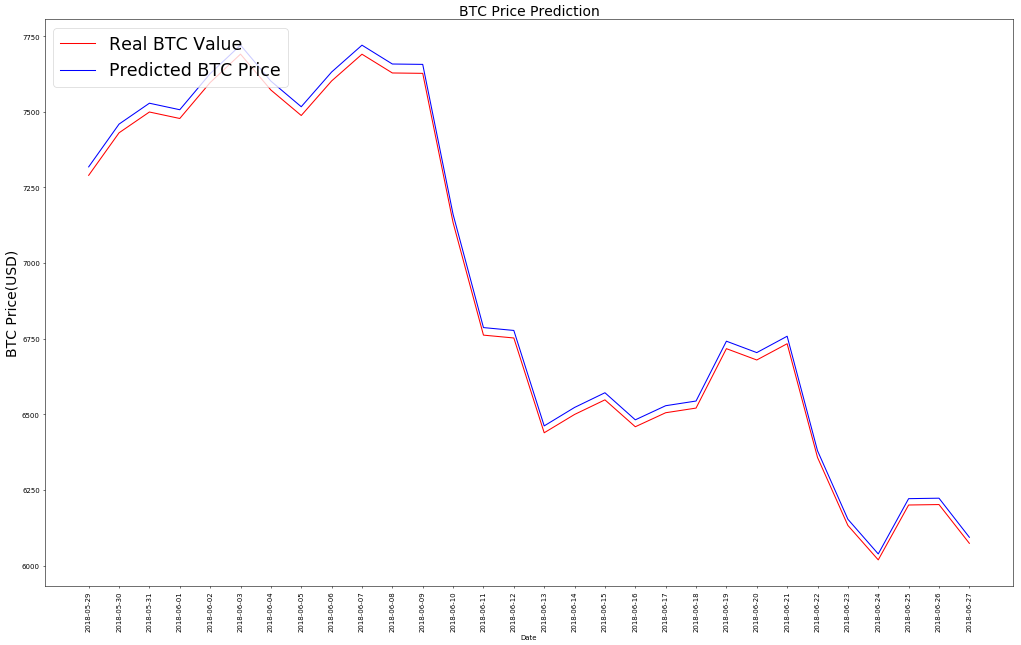

In [30]:
plotting (test_set,df_test, predicted_price)

Evaluation

In [9]:
mean_squared_error(test_set, predicted_price)

662.0635697418362

The preddictions were fairly accurate and followed the trends in the actual price flutuations for the period of 30 days. The mean squared error was 662 which is an indicator of relatively high accuracy.